## Experiments

Code for reproducing experiments shown in the paper

## Imports

In [1]:
%load_ext autoreload
%autoreload 2
import apoNN.src.data as apoData
import apoNN.src.utils as apoUtils
import apoNN.src.vectors as vectors
import apoNN.src.fitters as fitters
import apoNN.src.evaluators as evaluators
import apoNN.src.occam as occam_utils

import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import random
from ppca import PPCA
import inspect

[(['TEFF', 'LOGG', 'LOG10VDOP', 'METALS', 'C', 'N', 'O Mg Si S Ca Ti'], ['C', 'N', 'O', 'Na', 'Mg', 'Al', 'Si', 'S', 'K', 'Ca', 'Ti', 'V', 'Mn', 'Fe', 'Ni'], ['[C/M]', '[N/M]', '[O/M]', '[Na/H]', '[Mg/M]', '[Al/H]', '[Si/M]', '[S/M]', '[K/H]', '[Ca/M]', '[Ti/M]', '[V/H]', '[Mn/H]', '[Fe/H]', '[Ni/H]'], [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1])]


we use the [```apogee```](https://github.com/jobovy/apogee) module for interacting with APOGEE data and make use of dr16

In [2]:
import apogee.tools.path as apogee_path
apogee_path.change_dr(16)

### Hyperparameters

For speed we can run the results using only a subset of spectra

In [3]:
n_start = 0
n_stars = 100000
d = 100 #number of dimensions to use for compression
tol = 0.01 # tolerance to use for PPCA. Larger means faster but less accurate

## Setup

We load the AllStar file and make appropriate datacuts. This yields ```alllStar_occamlike``` - a large dataset containing all those spectra matching the dataset cuts in the data release 16 - and ```allStar_occam``` containing those stars within ```alllStar_occamlike``` cross-matched with the occam open cluster dataset.

In [4]:
allStar = apoUtils.load("shuffled_allStar")


In [5]:
upper_temp_cut = allStar["Teff"]<5000
lower_temp_cut = allStar["Teff"]>4000
lower_g_cut = allStar["logg"]>1.5
upper_g_cut = allStar["logg"]<3.
occamlike_cut = lower_g_cut & upper_g_cut & lower_temp_cut & upper_temp_cut
allStar_occamlike =  allStar[np.where(occamlike_cut)]


occam = occam_utils.Occam()
occam_kept = occam.cg_prob>0.8
allStar_occam,cluster_idxs = occam_utils.prepare_occam_allStar(occam_kept,allStar_occamlike)



We convert allStar files into the continuum-normalized spectra using ```apoData.Dataset```

In [ ]:
data_occamlike = apoData.Dataset(allStar_occamlike[n_start:n_start+n_stars])
data_occam = apoData.Dataset(allStar_occam)


```cluster_idxs``` contains the clusters to which entries in ```data_occam``` belong

In [ ]:
assert(cluster_idxs.shape[0] == data_occam.masked_spectra.shape[0])

## Compression

```apoData.Dataset``` returns spectra for which bins with errors above a threshold are masked. We run a PCA that naturally handles missing values using the [ppca module](https://github.com/allentran/pca-magic). This is wrapped in a function ```fitters.compress_masked_spectra``` 

In [34]:
mask_interstellar, interstellar_locs = apoUtils.get_interstellar_bands()

In [64]:
z,z_occam,ppca = fitters.compress_masked_spectra(data_occamlike.masked_spectra[:,mask_interstellar],data_occam.masked_spectra[:,mask_interstellar],d,tol=tol)


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds

/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:82: RuntimeWarning: divide by zero encountered in log
  det = np.log(np.linalg.det(Sx))

1.0
0.25088724406412743
0.005515533244478066
0.015138256792525118
0.014447737721581255
0.012479052384481548
0.010986942358980123
0.009939975953654367


In [47]:
#z,z_occam,ppca = fitters.compress_masked_spectra(data_occamlike.masked_spectra,data_occam.masked_spectra,d,tol=tol)
z,z_occam,ppca = fitters.compress_masked_spectra(data_occamlike.masked_spectra,data_occam.masked_spectra,d,tol=tol)


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds

/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:82: RuntimeWarning: divide by zero encountered in log
  det = np.log(np.linalg.det(Sx))

1.0
0.27505911535233074
0.0070751358132370434
0.014637514741570046
0.013805840321605367
0.011820993737605145
0.01033202899653829
0.009255354063819943


As stated in the paper, our evaluation method requires using our approach on unseen clusters through a cross-validation scheme. This is handled through the ```evaluators.StandardEvaluator``` class which takes ```vectors.Vector``` as inputs. It is run as follows.

In [65]:
Z_occam = vectors.OccamVector(val = z_occam,cluster_names=cluster_idxs).remove_orphans()
Z = vectors.Vector(val = z)

The vectors come with lots of handy functions. For example we can see which stars belong to which clusters using ```vectors.OccamVector.registry``` or even remove a cluster using ```vectors.OccamVector.without()```

In [12]:
Z.val.shape

(100000, 100)

In [15]:
Z_occam.registry

{'NGC 4337': array([92, 93]),
 'NGC 6819': array([135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
        148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
        161, 162, 163]),
 'NGC 2158': array([47, 48, 49, 50, 51, 52, 53, 54]),
 'NGC 1798': array([27, 28, 29, 30, 31, 32]),
 'NGC 188': array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]),
 'NGC 2243': array([67, 68, 69, 70, 71]),
 'IC 1369': array([20, 21]),
 'Berkeley 20': array([ 9, 10]),
 'NGC 2304': array([72, 73]),
 'NGC 2420': array([74, 75, 76, 77, 78, 79, 80, 81, 82, 83]),
 'NGC 6791': array([ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
        109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
        122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134]),
 'Trumpler 5': array([178, 179, 180, 181, 182, 183, 184]),
 'NGC 6705': array([94, 95]),
 'Berkeley 53': array([11, 12, 13]),
 'Berkeley 17': array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 'C

In [ ]:
Z_occam.without("NGC 6791").registry

## Baseline

As our baseline we use the AstroNN abundances. We use the ```vectors.AstroNNVector``` to create an AstroNN vector from an allStar file. Parameters included in the vector are passed through a ```considered_parameters``` input

In [17]:
considered_parameters = ["Fe_H","C_FE","N_FE","O_FE","Na_FE","Mg_FE","Al_FE","Si_FE","S_FE","K_FE","CA_FE","Ni_FE","Cr_FE","Co_FE"] 
#considered_parameters = ["AK_targ"]

In [18]:
#element_string = "[Fe/H], "
#for param in considered_parameters[1:]:
#    s1,s2 = param.split("_")
#    element_string+=f"[{s1}/{s2}], "
#print(element_string)

In [19]:
Y = vectors.AstroNNVector(allStar_occamlike[n_start:n_start+n_stars],considered_parameters).remove_nan_cols()
#because one of the entries in the AstroNN catalogue contains nan. we remove it with Y.remove_nan_cols()
Y_occam = vectors.AstroNNVector(allStar_occam,considered_parameters)
Y_occam = vectors.OccamVector(cluster_names=cluster_idxs, val = Y_occam.val).remove_orphans()

In [20]:
print(inspect.getsource(vectors.AstroNNVector))

class AstroNNVector(Vector):
    def __init__(self,allStar,params):
        self.astroNN_hdul = fits.open("/share/splinter/ddm/modules/turbospectrum/spectra/dr16/apogee/vac/apogee-astronn/apogee_astroNN-DR16-v0.fits")
        self.allStar = allStar
        self.params = params
        ids = self.get_astroNN_ids(self.allStar)
        cut_astroNN = self.astroNN_hdul[1].data[ids]
        self._val = self.generate_abundances(cut_astroNN,self.params)
        
        
    def get_astroNN_ids(self,allStar):
        desired_ids= []
        astroNN_ids = list(self.astroNN_hdul[1].data["Apogee_id"])
        for apogee_id in allStar["APOGEE_ID"]:
            desired_ids.append(astroNN_ids.index(apogee_id))
        return desired_ids
    
    
    def generate_abundances(self,astroNN,params):
        values = []
        for i,p in enumerate(params):
            fe_h = astroNN["FE_H"]
            if p in ["Teff","logg","Fe_H"]:
                values.append(astroNN[p])
            else:
          

### Plotting performance against number of components

For our experiment we want to determine how performance compares with the number of dimensions preserved in the PCA step. We also want to compare against the performance obtained using abundances.

There are two ingredients required for assessing performance

- a ```fitters.Fitter``` object that takes vectors (spectra, stellar parameters) and scales them to encode chemical similarity. 

- a ```evaluators.Evaluator``` object that takes a fitter, and unsupervised dataset, an occam dataset and calculates the doppelganger rates of a representation.

In [20]:
print(inspect.getsource(evaluators.BaseEvaluator))

class BaseEvaluator(abc.ABC):
    """Base class from which all evaluators are derived. This is an abstract class so is never called directly."""
    def __init__(self,z,z_occam,leave_out=True):
        pass
    
    
    @abc.abstractmethod
    def get_distances(self):
        pass
    

    @staticmethod
    def get_combinations(len_cluster):
        """
        Given a cluster size returns a list containing every index combination forming valid pairs (without repeat pairs) 
        """
        combinations = []
        for idx1 in np.arange(len_cluster):
            for idx2 in np.delete(np.arange(len_cluster),idx1):
                if sorted([idx1,idx2]) not in combinations:
                    combinations.append(sorted([idx1,idx2]))
        return combinations
    
    
    @staticmethod
    def get_doppelganger_rate(distances,random_distances,registry):
        """
        INPUTS
        distances: nested list or array containing intracluster distances. len of upper list should m

In [14]:
def simple_fitter(z,z_occam):
    """This is a simple fitter that just scales the dimensions of the inputed representation. Which is used as a baseline"""
    return fitters.SimpleFitter(z,z_occam,use_relative_scaling=True,is_pooled=True,is_robust=True)


In [15]:
def standard_fitter(z,z_occam):
    """This fitter performs a change-of-basis to a more appropriate basis for scaling"""
    return fitters.StandardFitter(z,z_occam,use_relative_scaling=True,is_pooled=True)


In [23]:
evaluator_Y = evaluators.StandardEvaluator(Y,Y_occam,leave_out=True,fitter_class=standard_fitter)
evaluator_Y.weighted_average

0.022415915720714864

In [41]:
evaluator_Y_overfit = evaluators.StandardEvaluator(Y,Y_occam,leave_out=False,fitter_class=standard_fitter)
evaluator_Y_overfit.weighted_average

0.012543997941559868

In [24]:
n_components = [5,15,25,35,45,55,65,75,85,95]
evaluators_X = [evaluators.StandardEvaluator(Z[:,:n_component],Z_occam[:,:n_component],leave_out=True,fitter_class=standard_fitter) for n_component in n_components]

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicin

we can pass ```leave_out=False``` in which case the (overfitted) results without cross-validation are shown

In [25]:
evaluators_X_overfit = [evaluators.StandardEvaluator(Z[:,:n_component],Z_occam[:,:n_component],leave_out=False,fitter_class=standard_fitter) for n_component in n_components]

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicin

(0, 0.06)

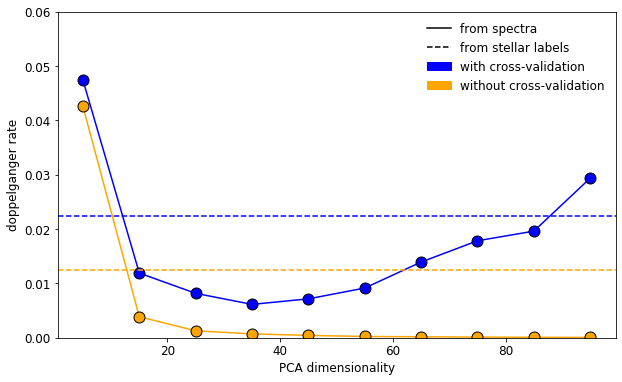

In [125]:
import matplotlib
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
font = {'family' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

plt.figure(figsize=[10,6])

plt.plot(n_components,np.array([i.weighted_average for i in evaluators_X]),label="with cross-validation",color="blue",marker='o',markersize=11,markeredgecolor="black")
plt.plot(n_components,np.array([i.weighted_average for i in evaluators_X_overfit]),label="without cross-validation",color="orange",marker='o',markersize=11,markeredgecolor="black")
plt.axhline(y=evaluator_Y.weighted_average,c="blue",linestyle  = "--",label="stellar labels")
plt.axhline(y=evaluator_Y_overfit.weighted_average,c="orange",linestyle  = "--",label="from stellar labels")
plt.ylabel("doppelganger rate")
plt.xlabel("PCA dimensionality")


dashed_line = mlines.Line2D([], [], color="black",linestyle="--",
                          markersize=15, label='from stellar labels')
full_line = mlines.Line2D([], [], color="black",linestyle="-",
                          markersize=15, label='from spectra')
blue_patch = mpatches.Patch(color='blue', label='with cross-validation')
orange_patch = mpatches.Patch(color='orange', label='without cross-validation')


plt.legend(handles=[full_line,dashed_line,blue_patch,orange_patch],frameon=False)
#plt.legend(frameon=False)
plt.savefig("../../figures/global_doppelganger.pdf",format="pdf")
plt.ylim(0,0.06)
#plt.title("Doppelganger rate per star")

### Fine grained investigation into cluster level performance

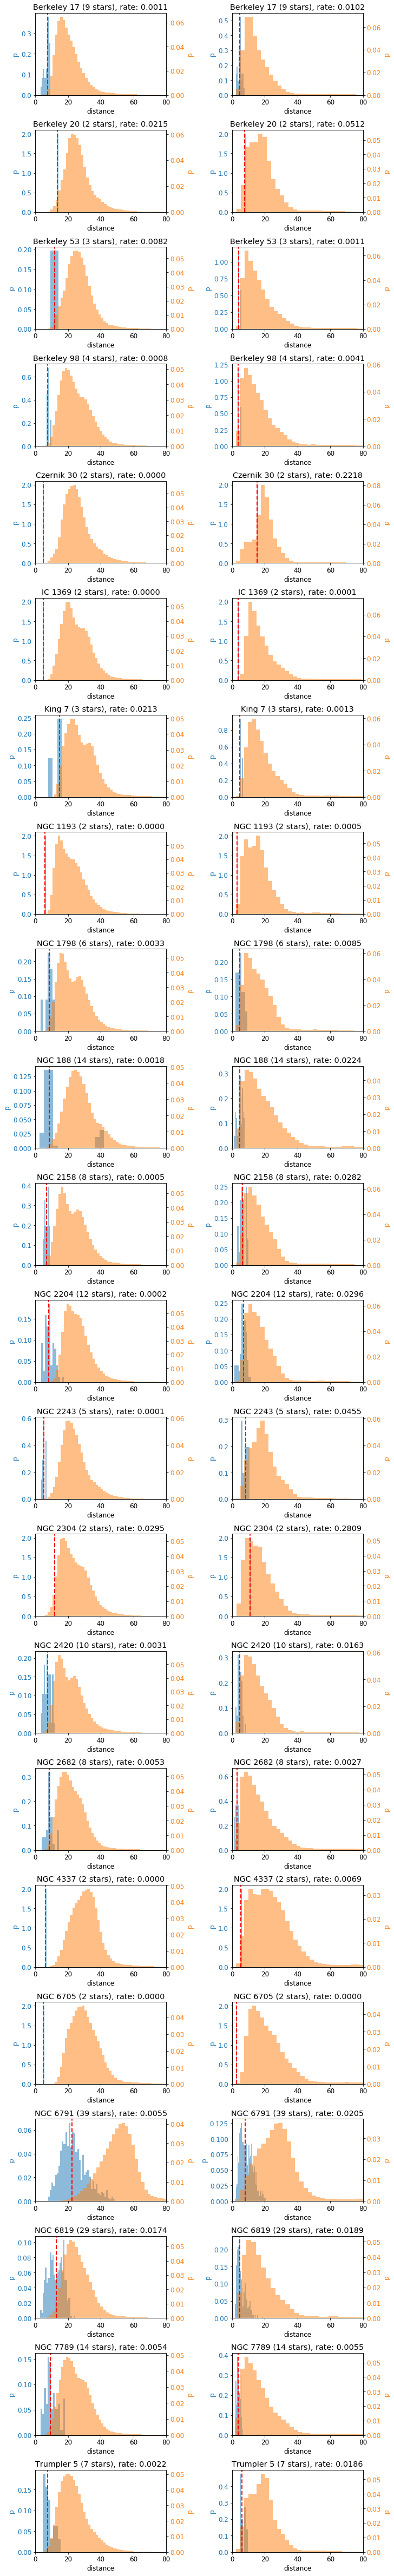

In [93]:
n_rows = 22
fig = plt.figure(constrained_layout=True,figsize=[10,3*n_rows])
gspec = gridspec.GridSpec(ncols=2, nrows=n_rows, figure=fig)
#for i in range(len(sorted(spectra_evaluator.registry))):
for i in range(n_rows):
    spec_ax = fig.add_subplot(gspec[i, 0])
    evaluators_X[3].plot_cluster(sorted(evaluators_X[3].registry)[i],spec_ax,x_max=80)
    abund_ax = fig.add_subplot(gspec[i, 1])
    evaluator_Y.plot_cluster(sorted(evaluator_Y.registry)[i],abund_ax,x_max=80)
    
plt.savefig("../../figures/local_doppelganger.pdf",format="pdf")


### Plotting performance against open clusters

We plot the performance obtained against the number of open-clusters used.

In [94]:
n_repeats = 20 #How many different combinations of clusters to sample for each size
n_clusters_considered = [10,15,20,22] #How many clusters to preserve
n_component = 25

In [95]:
def get_n_random_clusters(vector_occam,n_clusters):
    cluster_list = random.sample(list(vector_occam.registry),n_clusters)
    return vector_occam.only(cluster_list)

In [96]:
res = []
for n_clusters in n_clusters_considered:
    res.append([])
    for _ in range(n_repeats):
        Z_restricted = get_n_random_clusters(Z_occam,n_clusters)
        evaluator_X = evaluators.StandardEvaluator(Z[:,:n_component],Z_restricted[:,:n_component],leave_out=True,fitter_class=standard_fitter)
        res[-1].append(evaluator_X.weighted_average)

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicin

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicin

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicin

In [97]:
[np.mean(res_i) for res_i in res]

[0.014612514301279795,
 0.013078374115114167,
 0.008124393565502082,
 0.008177778378378379]

In [98]:
res_y = []
for n_clusters in n_clusters_considered:
    res_y.append([])
    for _ in range(n_repeats):
        Y_restricted = get_n_random_clusters(Y_occam,n_clusters)
        evaluator_Y = evaluators.StandardEvaluator(Y,Y_restricted,leave_out=True,fitter_class=standard_fitter)
        res_y[-1].append(evaluator_Y.weighted_average)

In [99]:
[np.mean(res_i) for res_i in res_y]

[0.030574616829552082,
 0.02381988259497865,
 0.021629260304345838,
 0.022415737336984973]

In [100]:
[np.mean(res_i) for res_i in res_y]

[0.030574616829552082,
 0.02381988259497865,
 0.021629260304345838,
 0.022415737336984973]

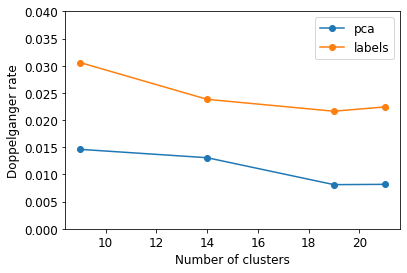

In [126]:
plt.plot(np.array(n_clusters_considered)-1,[np.mean(res_i) for res_i in res],label="pca",marker='o')
plt.plot(np.array(n_clusters_considered)-1,[np.mean(res_i) for res_i in res_y],label="labels",marker='o')

#np.array(n_clusters_considered)-1 because one cluster removed from scaling when evaluated on leave-out=True 

plt.xlabel("Number of clusters")
plt.ylabel("Doppelganger rate")
plt.ylim(0.,0.04)
plt.legend()
plt.savefig("../../figures/doppelganger_vs_clusters.pdf",format="pdf")


### Plotting performance against dataset size

We investigate how much the PCA compression is affected by the dataset size.

In [127]:
def get_Zs(data,data_occam,d,tol,n_stars = 1000):
    kept_idxs = np.random.choice(len(data.masked_spectra),n_stars,replace=False)
    z,z_occam,ppca = fitters.compress_masked_spectra(data.masked_spectra[kept_idxs],data_occam.masked_spectra,d,tol=tol)
    Z_occam = vectors.OccamVector(val = z_occam,cluster_names=cluster_idxs).remove_orphans()
    Z = vectors.Vector(val = z)
    return Z,Z_occam

In [128]:
dataset_sizes = [10000,20000,30000,40000,50000]
n_repeats = 5
d=25

In [129]:
res_datasize = []
for dataset_size in dataset_sizes:
    res_datasize.append([])
    for _ in range(n_repeats):
        Z,Z_occam = get_Zs(data_occamlike,data_occam,d=d,tol=0.1,n_stars = dataset_size)
        evaluator = evaluators.StandardEvaluator(Z,Z_occam,leave_out=True,fitter_class=standard_fitter)
        res_datasize[-1].append(evaluator.weighted_average)

/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds

1.0
0.5092300095686184
0.0099566140357501
0.022504871861352416
0.014882581293900077
0.010232864240825146
0.006984030852267398
/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds

1.0
0.6417961316508023
0.006431012167728678
0.023653642885207105
0.016625542434145157
0.011399876454146418
0.007528109140258921
/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (X - self.means) / self.stds

1.0
0.7608772209570747
0.004766706258857112
0.025297125984370172
0.016437782426429792
0.010892235127554661
0.0077196853865521
/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ppca/_ppca.py:23: RuntimeWarning: invalid valu

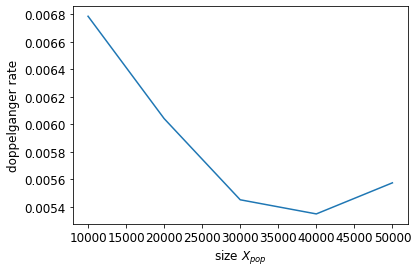

In [130]:
plt.plot(dataset_sizes,np.mean(np.array(res_datasize).reshape(5,5),axis=1))
plt.xlabel(r"size $X_{pop}$")
plt.ylabel("doppelganger rate")
plt.savefig("../../figures/doppelganger_vs_Xsize.pdf",format="pdf")


In [131]:
res_datasize[1]

[0.007592972972972973,
 0.006077297297297298,
 0.005107837837837838,
 0.006103243243243243,
 0.005323783783783783]

In [132]:
kept_idxs = np.random.choice(len(data_occamlike.masked_spectra),100,replace=False)
kept_idxs

array([28592, 91798,   358, 83755, 33002, 19810, 57096, 36318, 45988,
       39992, 19128, 27104, 74147, 58905, 60962, 23097, 33091, 17747,
       33742, 51499, 26262, 32453, 11699, 34769, 93493, 62452, 69652,
       10404, 80652, 94461, 37768, 71742, 30344,   397,  2587, 99340,
       91046, 12668, 77135, 44936, 99346, 38082, 30174, 46818, 98997,
       18589, 70333, 77472, 30799,  4537, 86591, 11519, 64910, 81241,
       39600, 99059, 36580, 65381, 10319, 12656, 67190, 39149, 98957,
       74399, 26788, 67347, 62294, 45990, 28763, 73652, 45038, 81251,
       75580, 78047, 59908,  7857, 39826, 28862, 18517, 48846, 90230,
       98257, 73255, 41647, 47588, 17125, 76132, 69557, 24562, 17091,
       30661, 93246, 78294, 94235,  9949, 98075, 78325, 72695,  3772,
       23451])

### Measure correlation between similarity and other parameters

In [49]:
def similarity_ij(i,j,v):
    return np.linalg.norm(v[i]-v[j])

def get_similarity(X,Y,n_repeats=10000,n_max=10000):
    """
    OUTPUTS
    -------
    similarity_list: 
        contains the chemical similarity for random pairs of stars
    delta_list:~
        contains the difference in variable of interest for these same stars
    """
    similarity_list = []
    delta_list = []
    for _ in range(n_repeats):
        i,j = np.random.choice(n_max,2)
        if  (Y[i]>-100) and (Y[j]>-100):
            similarity_list.append(similarity_ij(i,j,X))
            delta_list.append(np.abs(Y[i]-Y[j]))
    return similarity_list,delta_list

In [50]:
np.where(np.isnan(Y.val))

(array([], dtype=int64), array([], dtype=int64))

In [61]:
v_y.shape

(100000, 14)

In [51]:
Y.val.shape

(99997, 14)

In [66]:
#Y = vectors.AstroNNVector(allStar_occamlike[n_start:n_start+n_stars],considered_parameters)
#Y.val[np.isnan(Y.val)]=0
#Y_fitter = standard_fitter(Y,Y_occam)
#v_y = Y_fitter.transform(Y.centered(Y_occam)).val
Y_fitter = standard_fitter(Yb,Yb_occam)
v_y = Y_fitter.transform(Yb.centered(Yb_occam)).val

##########################################################

z_dim = 20
Z_fitter = standard_fitter(Z[:,:z_dim],Z_occam[:,:z_dim])
v_z = Z_fitter.transform(Z_fitter.z.centered(Z_occam[:,:z_dim])).val


/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")

/share/splinter/ddm/taggingProject/tidyPCA/apoNN/src/vectors.py:104: UserWarning: slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.
  warnings.warn("slicing OccamVectors only modifies the val and not the cluster_names/registry. Proceed with caution.")



In [67]:
param = "AK_TARG"
y_interest = allStar_occamlike[n_start:n_start+n_stars][param]

In [68]:
#y_interest = Y.val[:,0]

In [69]:
zs,delta_zs = get_similarity(v_z,y_interest)
ys,delta_ys = get_similarity(v_y,y_interest)

In [70]:
y_interest.shape

(100000,)

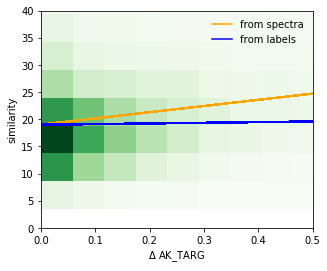

In [63]:
heatmap,xedges,yedges = np.histogram2d(delta_zs,zs,bins=[40,40])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.clf()
plt.imshow(heatmap.T,extent=extent,origin='lower',cmap="Greens",aspect=0.01)
plt.plot(delta_zs,np.poly1d(np.polyfit(delta_zs, zs, 1))(delta_zs),color="orange",label="from spectra")
plt.plot(delta_ys,np.poly1d(np.polyfit(delta_ys, ys, 1))(delta_ys),color="blue",label="from labels")
plt.legend(frameon=False)
plt.xlim(0,0.5)
plt.ylim(0,40)
plt.ylabel("similarity")
plt.xlabel(rf"$\Delta$ {param}")
plt.savefig("../../figures/extinction_trend_before.pdf",format="pdf")


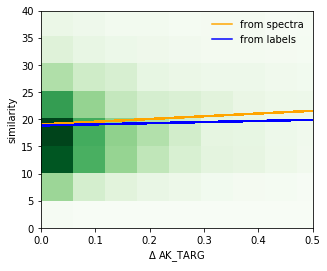

In [71]:
heatmap,xedges,yedges = np.histogram2d(delta_zs,zs,bins=[40,40])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.clf()
plt.imshow(heatmap.T,extent=extent,origin='lower',cmap="Greens",aspect=0.01)
plt.plot(delta_zs,np.poly1d(np.polyfit(delta_zs, zs, 1))(delta_zs),color="orange",label="from spectra")
plt.plot(delta_ys,np.poly1d(np.polyfit(delta_ys, ys, 1))(delta_ys),color="blue",label="from labels")
plt.legend(frameon=False)
plt.xlim(0,0.5)
plt.ylim(0,40)
plt.ylabel("similarity")
plt.xlabel(rf"$\Delta$ {param}")
plt.savefig("../../figures/extinction_trend_after.pdf",format="pdf")


Text(0.5, 0, '$\\Delta$ AK_TARG')

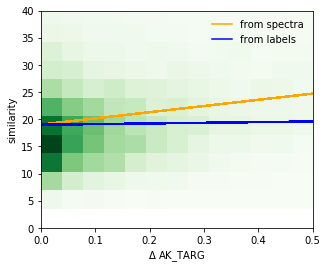

In [57]:
heatmap,xedges,yedges = np.histogram2d(delta_zs,zs,bins=[60,60])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.clf()
plt.imshow(heatmap.T,extent=extent,origin='lower',cmap="Greens",aspect=0.01)
plt.plot(delta_zs,np.poly1d(np.polyfit(delta_zs, zs, 1))(delta_zs),color="orange",label="from spectra")
plt.plot(delta_ys,np.poly1d(np.polyfit(delta_ys, ys, 1))(delta_ys),color="blue",label="from labels")
plt.legend(frameon=False)
plt.xlim(0,0.5)
plt.ylim(0,40)
plt.ylabel("similarity")
plt.xlabel(rf"$\Delta$ {param}")

In [305]:
np.mean(np.array(delta_zs)<0.2)

0.6919

(0, 100)

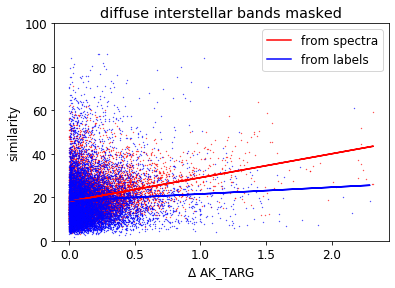

In [294]:
plt.scatter(delta_zs,zs,s=0.1,color="r")
plt.plot(delta_zs,np.poly1d(np.polyfit(delta_zs, zs, 1))(delta_zs),color="r",label="from spectra")
plt.scatter(delta_ys,ys,s=0.1,color="b")
plt.plot(delta_ys,np.poly1d(np.polyfit(delta_ys, ys, 1))(delta_ys),color="b",label="from labels")
plt.legend()
plt.title(param)
plt.title("diffuse interstellar bands masked")
plt.ylabel("similarity")
plt.xlabel(rf"$\Delta$ {param}")
#plt.xlim(0,1.0)
plt.ylim(0,100)

(0, 100)

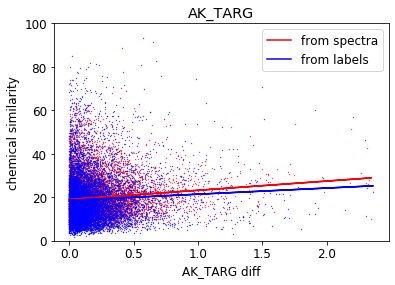

In [117]:
plt.scatter(delta_zs,zs,s=0.1,color="r")
plt.plot(delta_zs,np.poly1d(np.polyfit(delta_zs, zs, 1))(delta_zs),color="r",label="from spectra")
plt.scatter(delta_ys,ys,s=0.1,color="b")
plt.plot(delta_ys,np.poly1d(np.polyfit(delta_ys, ys, 1))(delta_ys),color="b",label="from labels")
plt.legend()
plt.title(param)
plt.ylabel("chemical similarity")
plt.xlabel(param+" diff")
#plt.xlim(0,1.0)
plt.ylim(0,100)

In [ ]:
#zs,delta_zs = get_similarity(Z_corrected.val,y_interest)
zs,delta_zs = get_similarity(Z_chem.val,y_interest)
zs2,delta_zs2 = get_similarity(Z_corr.val,y_interest)

ys,delta_ys = get_similarity(v_y,y_interest)

In [ ]:
#plt.scatter(delta_zs,zs,s=0.1,color="r")
plt.plot(delta_zs,np.poly1d(np.polyfit(delta_zs, zs, 1))(delta_zs),color="r",label="from spectra")
#plt.scatter(delta_ys,ys,s=0.1,color="b")
plt.plot(delta_ys,np.poly1d(np.polyfit(delta_ys, ys, 1))(delta_ys),color="b",label="from labels")
#plt.scatter(delta_zs2,zs2,s=0.1,color="g")
plt.plot(delta_zs2,np.poly1d(np.polyfit(delta_zs2, zs2, 1))(delta_zs2),color="g",label="from corrected spectra")
plt.legend()
plt.title(param)
plt.ylabel("chemical similarity")
plt.xlabel(param+" diff")
#plt.xlim(0,1.5)
plt.ylim(0,100)

In [ ]:
plt.scatter(delta_zs,zs,s=0.1,color="r")
plt.plot(delta_zs,np.poly1d(np.polyfit(delta_zs, zs, 1))(delta_zs),color="r",label="from spectra")
plt.scatter(delta_zs2,zs2,s=0.1,color="b")
plt.plot(delta_zs2,np.poly1d(np.polyfit(delta_zs2, zs2, 1))(delta_zs2),color="b",label="from labels")
plt.legend()
plt.title(param)
plt.ylabel("chemical similarity")
plt.xlabel(param+" diff")
#plt.xlim(0,1.5)
plt.ylim(0,100)

to do remove impact of parameter on representation

In [ ]:
#param ='AK_TARG'
param ='AK_TARG'

y_interest = allStar_occamlike[n_start:n_start+n_stars][param]
N = vectors.Vector(y_interest)

In [ ]:
N.val.shape

In [ ]:
Z_fitter = standard_fitter(Z[:,:z_dim],Z_occam[:,:z_dim])
Z_chem = Z_fitter.transform(Z_fitter.z.centered(Z_occam[:,:z_dim]))


In [ ]:
class LinearTransformation():
    def __init__(self,x,y):
        self.x = x
        self.y = y
    
    @property
    def val(self):
        return np.dot(self.y.centered().val.T,np.linalg.pinv(self.x.centered().val.T))
    
    def predict(self,vector:vectors.Vector):
        #need to return a Vector. So ncenteredeed to make this take the correct shape
        uncentered = np.dot(self.val,vector.centered().val.T).T
        centered = uncentered+np.mean(self.y.val,axis=0)
        return vectors.Vector(centered)                
        #return np.dot(self.val,vector.centered.T)
        

Z_chem_to_N  = LinearTransformation(Z_chem,N)


In [ ]:
np.mean(np.abs(Z_chem_to_N.val))

In [ ]:
N_pred = Z_chem_to_N.predict(Z_chem)

In [ ]:
plt.scatter(Z_chem_to_N.predict(Z_chem).val,N.val)

In [ ]:
Z_chem_to_N.val

In [ ]:
Z_corrected = vectors.Vector(Z_chem.val -1/((np.linalg.norm(Z_chem_to_N.val)**2))*((N_pred.val[:,None]-np.mean(N_pred.val))*(Z_chem_to_N.val[None,:])))

In [ ]:
jitter = 0.0001*np.random.normal(size = (Z_corrected.val.shape[0],1))*Z_chem_to_N.val[None,:]
Z_corrected = vectors.Vector(Z_corrected.val+jitter)

In [ ]:
plt.scatter(N.val,Z_chem_to_N.predict(Z_corrected).val,s=0.01)

In [ ]:
ridge = sklearn.linear_model.Ridge()
ridge.fit(Z_corrected.centered().val,N.val)

In [ ]:
plt.scatter(ridge.predict(Z_corrected.centered().val),N.val)

In [ ]:
np.mean(np.abs(Z_corrected.centered().val))

In [ ]:
Z_chem_to_N2  = LinearTransformation(Z_corrected,N)

In [ ]:
Z_chem_to_N.val/10000

In [ ]:
Z_chem_to_N2.val

In [ ]:
N_pred = Z_chem_to_N2.predict(Z_corrected)

In [ ]:
np.mean(np.abs(Z_chem_to_N.val))

In [ ]:
plt.scatter(N.val,N_pred.val)

In [ ]:
def iterative_nullsapce(Z,N,n_iter=100):
    """Z:variable that must be corrected
    N: Nuisance variable that must be removed
    n_iter: number of succesive iterations"""
    for _ in range(n_iter):
        linear = LinearTransformation(Z,N)
        N_pred = linear.predict(Z)
        plt.scatter(N.val,N_pred.val)
        plt.show()
        Z = vectors.Vector(Z.val -1/((np.linalg.norm(linear.val)**2))*((N_pred.val[:,None]-np.mean(N_pred.val))*(linear.val[None,:])))
        jitter = 0.01*np.random.normal(size = (Z.val.shape[0],1))*linear.val[None,:]
        Z = vectors.Vector(Z.val+jitter)
        N_pred = linear.predict(Z)
        plt.scatter(N.val,N_pred.val)
        plt.show()

    return Z

In [ ]:
Z_corrected = iterative_nullsapce(Z_chem,N,100)

In [ ]:
import apoNN.src.debias as debias


In [ ]:
debias.get_debiasing_projection(LinearSVC)

In [ ]:
from sklearn.linear_model import SGDClassifier,LogisticRegression

In [ ]:
Z_chem.val.shape

In [ ]:
binary_y = y_interest<np.median(y_interest)

In [ ]:
P, rowspace_projections, Ws  = debias.get_debiasing_projection(LogisticRegression,{},20,30,True,0.,Z_chem.val,binary_y,Z_chem.val,binary_y,by_class=False)

In [ ]:
Z_corr = vectors.Vector(np.dot(Z_chem.val,P))

In [ ]:
linear  = LinearTransformation(Z_chem,N)
N_pred = linear.predict(Z_chem)
plt.scatter(N_pred.val,N.val)

In [ ]:
linear  = LinearTransformation(Z_corr,N)
N_pred = linear.predict(Z_corr)
plt.scatter(N_pred.val,N.val)

In [ ]:
#finding which wavelengths are correlated with diffuse interstellar bands

In [ ]:
allStar_occam

In [ ]:
len(allStar_occam)

In [ ]:
Z_occam.registry

In [ ]:
cluster_ids = np.where(cluster_idxs=="NGC 2682")

In [ ]:
allStar_occam["AK_TARG"][cluster_ids]

Option: For PCA step restric ourselves to using stars with extremely similar extinctions

In [ ]:
Y.val.shape

In [ ]:
Y.val.shape

In [ ]:
Y.val.shape

In [16]:
Y_b = vectors.Vector(np.concatenate((Y.val,allStar_occamlike[n_start:n_start+n_stars]["ak_targ"][:,None]),axis=1))

NameError: name 'Y' is not defined

In [ ]:
Y_occam = vectors.AstroNNVector(allStar_occam,considered_parameters)
Y_occam_b = vectors.OccamVector(cluster_names=cluster_idxs,val = np.concatenate((Y_occam.val,allStar_occam[n_start:n_start+n_stars]["ak_targ"][:,None]),axis=1)).remove_orphans()

In [ ]:
Y_occam_b

In [ ]:
evaluator_Y = evaluators.StandardEvaluator(Y_b,Y_occam_b,leave_out=True,fitter_class=standard_fitter)
evaluator_Y.weighted_average

In [ ]:
data_occamlike.masked_spectra

In [ ]:
data_occamlike.masked_spectra[:,0].shape

In [ ]:
y_interest

In [ ]:
y_interest = allStar_occamlike[n_start:n_start+n_stars]["AK_targ"]
#y_interest = Y.val[:,0]

In [ ]:
len(np.where(data_occamlike.masked_spectra.mask[:,1010]==False)[0])

In [ ]:
plt.scatter( y_interest, data_occamlike.masked_spectra[:,500],s=0.1)


In [ ]:
len(np.where(data_occamlike.masked_spectra[5000].mask==False)[0])

In [ ]:
grad_extinction = []
for i in range(8575):
    safe_ids = np.where(data_occamlike.masked_spectra[i].mask==False)[0]
    grad_extinction.append(np.polyfit(y_interest[safe_ids], data_occamlike.masked_spectra[safe_ids,i], 1)[0])
    #print(np.polyfit(y_interest, data_occamlike.masked_spectra[:,i], 1)[0])

In [ ]:
plt.plot(apStarWavegrid(),grad_extinction)
plt.xlim(15250,15500)

In [ ]:
from apogee.tools import air2vac, atomic_number,apStarWavegrid

In [ ]:
apStarWavegrid()

In [ ]:
low_extinction_idxs = np.where(y_interest<0.025)

In [ ]:
from sklearn.linear_model import HuberRegressor, LinearRegression

In [ ]:
#linear = HuberRegressor()
linear = LinearRegression()

In [ ]:
linear.fit(y_interest[:,None],data_occamlike.masked_spectra[:,580:581])

In [ ]:
plt.scatter(y_interest,data_occamlike.masked_spectra[:,580:581],s=0.1)

In [ ]:
linear.coef_

In [ ]:
np.median(y_interest)

In [ ]:
considered_parameters

In [21]:
Yb = np.array([allStar_occamlike[n_start:n_start+n_stars][param] for param in considered_parameters]).T
Yb[np.where(Yb<-10)]=Y.val[np.where(Yb<-10)]
Yb = vectors.Vector(Yb)

In [27]:
Yb_occam = np.array([allStar_occam[n_start:n_start+n_stars][param] for param in considered_parameters]).T
Yb_occam[np.where(Yb_occam<-10)]=Y_occam.val[np.where(Yb_occam<-10)]

Yb_occam = vectors.OccamVector(val=Yb_occam,cluster_names = cluster_idxs)

## Removing Temperature trends from stellar spectra

In [233]:
data_occamlike.masked_spectra[:,mask_interstellar]

masked_array(
  data=[[0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        ...,
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=1e+20,
  dtype=float32)